In [1]:
import torch
import pickle
import os
from PIL import Image
from torch.nn.functional import softmax
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
from IPython.utils import io
torch.set_printoptions(sci_mode=False)

## General Setup

In [2]:
import platform
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [3]:
os.chdir(f"{ROOT_PATH}/4_Assessor/Category_Assessor/DinoV2")
from helpers_pipeline import *
from helper_DinoV2_Embeddings import *
id2label = pickle.load(open("id2label_dicts/category_id2label.pkl", "rb"))
label2id = {v: k for k, v in id2label.items()}
os.chdir(current_wd)

Using devices: DinoV2 device: cpu | SG2 device: mps | General device: mps


In [4]:
set_seed(42)
dino_device, sg2_device, device = set_device()

Using devices: DinoV2 device: cpu | SG2 device: mps | General device: mps


## Fixed Models Setup

In [5]:
# Products data and latents
target_feature = 'category'
df, latents = load_latents(target_feature)
latents = latents.to(sg2_device)

# SG2-Ada Generator
G = setup_generator()
G = G.to(sg2_device)

# DinoV2 Model 
dino_processor, dino_model = setup_dinov2()
dino_model = dino_model.to(dino_device)

# Attribute Classifier Model
classifier = load_classifier()
classifier = classifier.to(device)

In [6]:
# Freeeze all non-relevant model weights and set to eval mode
for param in G.parameters():
    param.requires_grad = False
G.eval()
for param in dino_model.parameters():
    param.requires_grad = False
dino_model.eval()
for param in classifier.parameters():
    param.requires_grad = False
classifier.eval();


In [7]:
# Print devoce for each model: 
print(f"Generator: {next(G.parameters()).device} | Requires Grad: {next(G.parameters()).requires_grad}")
print(f"DinoV2: {next(dino_model.parameters()).device} | Requires Grad: {next(dino_model.parameters()).requires_grad}")
print(f"Classifier: {next(classifier.parameters()).device} | Requires Grad: {next(classifier.parameters()).requires_grad}")

Generator: mps:0 | Requires Grad: False
DinoV2: cpu | Requires Grad: False
Classifier: mps:0 | Requires Grad: False


### Check gradient flow outside of Model Class

In [8]:
def plot_generated(img):
    img_out = (img.permute(0,2,3,1)*127.5 + 128).clamp(0,255).to(torch.uint8)
    img_out = Image.fromarray(img_out[0].cpu().numpy())
    return img_out

In [ ]:
from IPython.utils import io
torch.set_printoptions(sci_mode=False)

fixed_alpha = 0.9
fixed_class_idx = 7
latent = latents[0]

directions = torch.randn([8,16,512], device=latent.device, requires_grad=True)
directions_initial = directions.clone()[fixed_class_idx]

criterion = nn.MSELoss()
optimizer = torch.optim.Adam([directions], lr=0.01)


for i in range(5):
    optimizer.zero_grad()
    with io.capture_output() as captured:
        real_img = G.synthesis(latent, noise_mode='const')
    real_dino_input = dino_processor(real_img).to(dino_device)
    real_dino_embedding = dino_model(real_dino_input)['pooler_output'].to(device)
    real_scores = classifier(real_dino_embedding)
    real_probs = softmax(real_scores, dim = 1).squeeze(0)
    real_class_prob  = real_probs[fixed_class_idx]

    transformed_latent = latent + fixed_alpha * directions[fixed_class_idx]
    with io.capture_output() as captured:
        trans_img = G.synthesis(transformed_latent, noise_mode='const')
    trans_dino_input = dino_processor(trans_img).to(dino_device)
    trans_dino_embedding = dino_model(trans_dino_input)['pooler_output'].to(device)
    trans_scores = classifier(trans_dino_embedding)
    trans_probs = softmax(trans_scores, dim = 1).squeeze(0)
    trans_class_prob  = trans_probs[fixed_class_idx]

    loss = criterion((real_class_prob + fixed_alpha), trans_class_prob)
    loss.backward()
    optimizer.step()
    print(f"Step {i}: Loss: {loss.item()} | | Directions same: {torch.all(directions_initial == directions[fixed_class_idx])==False} | Directions gradient norm {directions.grad.norm()}")
    display(plot_generated(trans_img))
    directions_old = directions[fixed_class_idx]


### Torch Model Class

In [14]:
import torch
import torch.nn as nn
from torch.nn.functional import softmax
import numpy as np

class Editor(nn.Module):
    def __init__(self, generator, dino_model, dino_processor, classifier, id2label, label2id):
        super(Editor, self).__init__()
        self.generator = generator
        self.dino_model = dino_model
        self.dino_processor = dino_processor
        self.classifier = classifier

        self.id2label = id2label
        self.label2id = label2id   
        self.num_classes = len(id2label)
        self.directions = nn.Parameter(torch.randn(self.num_classes, 16, 512), requires_grad=True)
        self.alphas = np.arange(0,1,0.1)

    def forward(self, latent, class_idx=None, alpha = None):
        if class_idx == None:
            class_idx = torch.randint(0, self.num_classes, (1,), device=self.directions.device)
        
        if alpha == None:
            alpha = torch.tensor(np.round(np.random.choice(self.alphas),2), device=latent.device, dtype=torch.float32)
            print(alpha)
        # Processing for real image
        with io.capture_output() as captured:
            real_img = self.generator.synthesis(latent, noise_mode='const')
        real_dino_input = self.dino_processor(real_img).to(dino_model.device)
        real_dino_embedding = self.dino_model(real_dino_input)['pooler_output'].to(latent.device)
        real_scores = self.classifier(real_dino_embedding)
        real_probs = softmax(real_scores, dim=1).squeeze(0)
        print(real_probs)
        real_class_prob = real_probs[class_idx]

        # Processing for transformed image
        transformed_latent = latent + alpha * self.directions[class_idx].to(latent.device)
        with io.capture_output() as captured:
            transformed_img = self.generator.synthesis(transformed_latent, noise_mode='const')
        transformed_dino_input = self.dino_processor(transformed_img).to(dino_model.device)
        transformed_dino_embedding = self.dino_model(transformed_dino_input)['pooler_output'].to(latent.device)
        transformed_scores = self.classifier(transformed_dino_embedding)
        transformed_probs = softmax(transformed_scores, dim=1).squeeze(0)
        print(transformed_probs)
        transformed_class_prob = transformed_probs[class_idx]

        return real_class_prob, transformed_class_prob, class_idx, alpha


tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.1863,     0.0021,     0.0038,     0.7959,     0.0000,     0.0000,
            0.0119,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 0 (class: 5, alpha:0.5): Loss: 0.9999872446060181 | Directions gradient norm 1.3646968971547935e-11


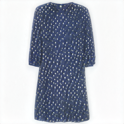

tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.1869,     0.0022,     0.0038,     0.7949,     0.0000,     0.0000,
            0.0122,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 1 (class: 5, alpha:0.5): Loss: 0.9999871253967285 | Directions gradient norm 7.825499778846279e-05


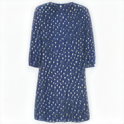

tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.3498,     0.0071,     0.0121,     0.6017,     0.0000,     0.0000,
            0.0293,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 2 (class: 5, alpha:0.5): Loss: 0.9999862909317017 | Directions gradient norm 5.689926911145449e-05


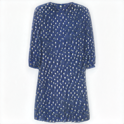

tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.0384,     0.0090,     0.0009,     0.5409,     0.0000,     0.0000,
            0.4107,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 3 (class: 5, alpha:0.5): Loss: 0.9999680519104004 | Directions gradient norm 0.000323246669722721


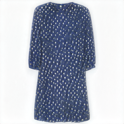

tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.0988,     0.0540,     0.0064,     0.0605,     0.0000,     0.0000,
            0.7802,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 4 (class: 5, alpha:0.5): Loss: 0.999943733215332 | Directions gradient norm 0.0006534743006341159


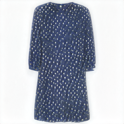

tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.2189,     0.0543,     0.0086,     0.2613,     0.0000,     0.0001,
            0.4568,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 5 (class: 5, alpha:0.5): Loss: 0.9997332096099854 | Directions gradient norm 0.004335422534495592


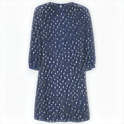

tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.0448,     0.0077,     0.0011,     0.6862,     0.0000,     0.0001,
            0.2601,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 6 (class: 5, alpha:0.5): Loss: 0.9997546672821045 | Directions gradient norm 0.0029504545964300632


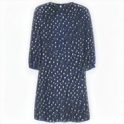

tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.0304,     0.2961,     0.0068,     0.0435,     0.0002,     0.0001,
            0.6229,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 7 (class: 5, alpha:0.5): Loss: 0.9997097253799438 | Directions gradient norm 0.00269328523427248


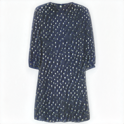

tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.0238,     0.1426,     0.0021,     0.2999,     0.0001,     0.0004,
            0.5310,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 8 (class: 5, alpha:0.5): Loss: 0.9991118311882019 | Directions gradient norm 0.006625603884458542


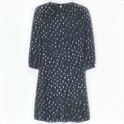

tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.0072,     0.0118,     0.0003,     0.9204,     0.0000,     0.0011,
            0.0592,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 9 (class: 5, alpha:0.5): Loss: 0.9978531002998352 | Directions gradient norm 0.025425804778933525


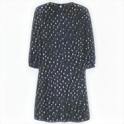

tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.0048,     0.0124,     0.0003,     0.9507,     0.0001,     0.0024,
            0.0294,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 10 (class: 5, alpha:0.5): Loss: 0.9951868653297424 | Directions gradient norm 0.03351864218711853


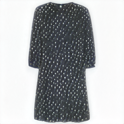

tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.0040,     0.0071,     0.0001,     0.9668,     0.0001,     0.0041,
            0.0178,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 11 (class: 5, alpha:0.5): Loss: 0.991749107837677 | Directions gradient norm 0.0718061774969101


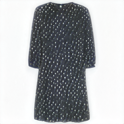

tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.0053,     0.0226,     0.0006,     0.9325,     0.0013,     0.0206,
            0.0172,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 12 (class: 5, alpha:0.5): Loss: 0.9592692852020264 | Directions gradient norm 0.48889315128326416


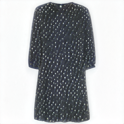

tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.0030,     0.0331,     0.0012,     0.8764,     0.0059,     0.0604,
            0.0200,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 13 (class: 5, alpha:0.5): Loss: 0.8829284310340881 | Directions gradient norm 0.9348621368408203


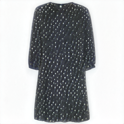

tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.0023,     0.0334,     0.0018,     0.6362,     0.0312,     0.2892,
            0.0058,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 14 (class: 5, alpha:0.5): Loss: 0.5051694512367249 | Directions gradient norm 3.070769786834717


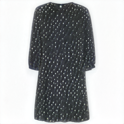

tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.0001,     0.0051,     0.0003,     0.1829,     0.0479,     0.7635,
            0.0002,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 15 (class: 5, alpha:0.5): Loss: 0.055918026715517044 | Directions gradient norm 1.5586016178131104


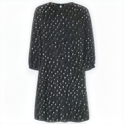

tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.0000,     0.0013,     0.0002,     0.0262,     0.0518,     0.9206,
            0.0000,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 16 (class: 5, alpha:0.5): Loss: 0.006310959346592426 | Directions gradient norm 0.04735780507326126


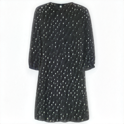

tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.0000,     0.0079,     0.0020,     0.0234,     0.1267,     0.8400,
            0.0000,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 17 (class: 5, alpha:0.5): Loss: 0.02559453435242176 | Directions gradient norm 0.3961258828639984


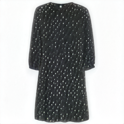

tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.0000,     0.0298,     0.0117,     0.0338,     0.2167,     0.7077,
            0.0002,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 18 (class: 5, alpha:0.5): Loss: 0.08541743457317352 | Directions gradient norm 1.0636787414550781


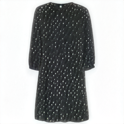

tensor([    0.1618,     0.0020,     0.0007,     0.1013,     0.0000,     0.0000,
            0.7341,     0.0000], device='mps:0')
tensor([    0.0000,     0.0164,     0.0104,     0.0275,     0.2204,     0.7252,
            0.0001,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)
Step 19 (class: 5, alpha:0.5): Loss: 0.07549181580543518 | Directions gradient norm 0.7507486343383789


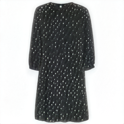

In [20]:
# Assuming all components are properly setup and moved to the correct device
latent = latents[0]
editor = Editor(G, dino_model, dino_processor, classifier, id2label, label2id)
optimizer = torch.optim.Adam(editor.parameters(), lr=0.01)
criterion = nn.MSELoss()

old_directions = editor.directions.clone()
for i in range(20):
    optimizer.zero_grad()
    real_class_prob, transformed_class_prob, class_idx, alpha = editor(latent, class_idx = 5, alpha=0.5)
    loss = criterion(torch.tensor(1.00, device=transformed_class_prob.device), transformed_class_prob)

    loss.backward()
    optimizer.step()
    print(f"Step {i} (class: {class_idx}, alpha:{alpha}): Loss: {loss.item()} | Directions gradient norm {editor.directions.grad.norm()}")
    transformed = latent + 0.5 * editor.directions[5].to(latent.device)
    out_img = plot_generated(G.synthesis(transformed, noise_mode='const'))
    display(out_img.resize([124, 124]))


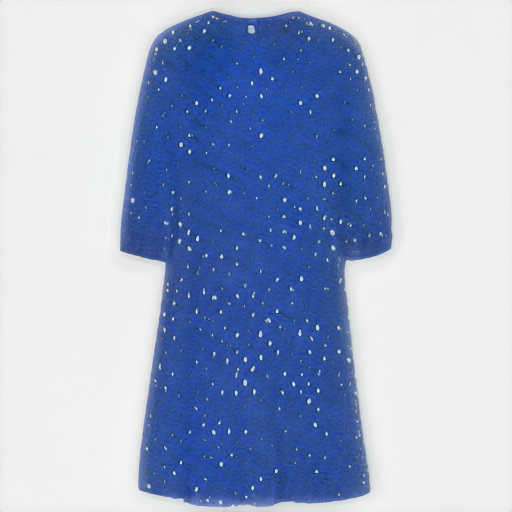

In [16]:
transformed_latent = latent + 0.5 * editor.directions[5].to(latent.device)
out_img = plot_generated(G.synthesis(transformed_latent, noise_mode='const')).resize([512, 512])
out_img

In [19]:
# Test the classification: 
dino_input = dino_processor(G.synthesis(transformed_latent, noise_mode='const')).to(dino_model.device)
dino_embedding = dino_model(dino_input)['pooler_output'].to(device)
scores = classifier(dino_embedding)
probs = softmax(scores, dim=1).squeeze(0)
probs

tensor([    0.0000,     0.0002,     0.0000,     0.0305,     0.0011,     0.9682,
            0.0000,     0.0000], device='mps:0', grad_fn=<SqueezeBackward1>)